In [1]:
# %pip install opencv-python
# %pip install --upgrade numpy

In [15]:
from skimage import data , filters     # skimage is a library for image processing
import skimage.io as io
# Show the figures / plots inside the notebook
from matplotlib import pyplot as plt
from skimage.color import rgb2gray,rgb2hsv
from skimage.exposure import histogram
from matplotlib.pyplot import bar
# utility libraries
import numpy as np
import math
import cv2
import sys
# import preprocessing module
sys.path.append('../')
from Preprocessing import preprocessing as pp

In [111]:
def extract_roi(edge_image, gray_image):
  """
  Extracts the region of interest (ROI) from an edge-filtered image.

  Args:
      edge_image: A grayscale image with edges detected.

  Returns:
      A list of tuples, where each tuple contains the following information for an ROI:
          - (x_min, y_min): Coordinates of the top-left corner.
          - (x_max, y_max): Coordinates of the bottom-right corner.
          - normalized_signature: Normalized signature of the ROI.
          - shape_type: Type of shape detected (e.g., "circle").
  """

  # Find contours in the edge image
  # mode: cv2.RETR_EXTERNAL retrieves only the extreme outer contours (boundries) and ignore nested inside contours

  # When you detect contours in an image, each contour is a list of points that form the boundary of the object. However,
  # not all of these points are always necessary to accurately describe the shape. 
  # `cv2.CHAIN_APPROX_SIMPLE` is an algorithm that reduces the number of points in the contour. It removes all redundant 
  # points and compresses the contour, thereby saving memory.
  # It does this by storing only the end points of the horizontal, vertical, and diagonal line segments that make up the contour. 

  # contours: list of contours where each contour is a Numpy array of (x, y) coordinates of boundary points of the object
  contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # List to store extracted ROIs
  extracted_rois = []

  # Minimum area threshold to avoid small objects and retrieve only potential ROIs
  min_area = 100

  # Iterate through each contour
  for contour in contours:
    # Calculate area of the contour
    area = cv2.contourArea(contour)

    # Skip small contours
    if area < min_area:
      continue

    # Gets the smallest possible circle that encloses the contour with its centroid and radius
    closest_point, radius = cv2.minEnclosingCircle(contour)

    # Get bounding rectangle of the contour
    # x, y: Coordinates of the top-left corner
    # w, h: Width and height of the rectangle
    x, y, w, h = cv2.boundingRect(contour)

    #________________________________________________________________________________________________________________________________

    # Calculate centroid of the contour
    # M['m00'] : Area of contour
    # M["m10"] / M["m00"] : x coordinate of the centroid
    # M["m01"] / M["m00"] : y coordinate of the centroid
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # Find the point closest to the upper right corner
    top_right = (x + w, y)

    # Calculate distances between centroid and perimeter
    distances = []
    for i in range(len(contour)):
      distance = np.linalg.norm(contour[i][0] - closest_point)
      distances.append(distance)

    # Normalize distances
    normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    #________________________________________________________________________________________________________________________________

    # Calculate the area of the enclosing circle
    circle_area = np.pi * (radius ** 2)

    # If the aspect ratio and extent are approximately 1 and the areas are approximately equal, 
    # add the contour to the list of circle contours
    if  np.isclose(area, circle_area, rtol=0.4):  # 40% tolerance
        cv2.rectangle(edge_image, (x, y), (x + w, y + h), (255, 0, 0), 3)
        sub_image = gray_image[y-20:y+h+20, x-20:x+w+20]
        pp.show_images([sub_image], ["contour"])


    # Store extracted ROI information
    extracted_rois.append({
      "x_min": x,
      "y_min": y,
      "x_max": x + w,
      "y_max": y + h,
      "normalized_signature": normalized_distances,
      "shape_type": None
    })

  # Return the list of extracted ROIs
  return extracted_rois


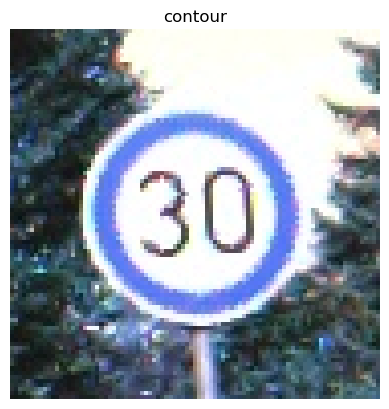

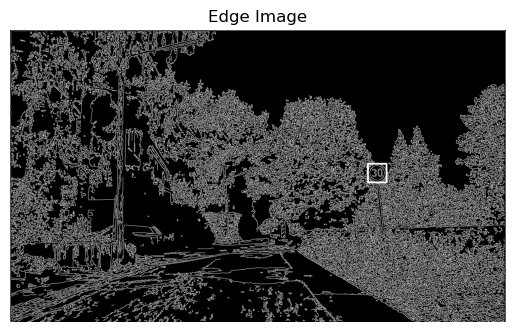

In [112]:
'''
Testing
'''

# Load the image
image = cv2.imread("../dataset/testcase4.jpg")

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edge_image = cv2.Canny(gray_image, 50, 150)

# pp.show_images([gray_image, edge_image], ["Grayscale Image", "Edge Image"])

# Extract ROIs
rois = extract_roi(edge_image, image)
pp.show_images([edge_image], ["Edge Image"])


